In [1]:
from ResComp import *
from matplotlib import pyplot as plt
import networkx as nx

## A Comparison of the Predictive Power of 
 1. Random Networks
 2. Specialization from random network
 3. Specialization with random edge weights
 4. Configuration model

In [11]:
BEGIN      = 0
END        = 3
TIMESTEPS  = 2000
X0         = [.5, 0, -.5]
FNAME      = "/Users/djpassey/Code/work/NetworkResearch/UVMproject/data/specRandNets/specNetw{}.csv"
NUM_SPECI  = 1042
BINS = [0,5,10,15,20,40,80,100]

In [20]:
def lorenz_equ(x0=X0, begin=BEGIN, end=END, timesteps=TIMESTEPS):
    t = np.linspace(begin,end,timesteps)
    train_t = t[:len(t)//2]
    u = integrate.solve_ivp(lorentz_deriv, (begin,end),x0, dense_output=True).sol
    return t, train_t, u
# end

def error(u,pre):
    return np.mean(np.sum((u - pre)**2, axis=0)**.5)

def config_model(A):

    # Get in and out deg distributions
    G    = nx.DiGraph(A)
    din  = sorted([ d for n,d in G.in_degree()], reverse=True)
    dout = sorted([d for n,d in G.out_degree()], reverse=True)
    
    # Create new adj matrix
    M    = nx.directed_configuration_model(din,dout, create_using=nx.DiGraph)
    M    = nx.DiGraph(M) # Removes parellel edges
    M    = nx.adj_matrix(M).toarray()
    
    return M
# end

def lorenz_experiment(params):
    t, train_t, u = lorenz_equ(**params["diff_eq_params"])
    for i in range(params["num_trials"]):
        rc = ResComp(3,3, **params["res_params"])
        rc.fit(train_t,u)
        params["mse_error"].append( error(u(t), rc.predict(t)) )
    # end
# end

def spec_experiment(params):
    t, train_t, u = lorenz_equ(**params["diff_eq_params"])
    for i in range(1,(NUM_SPECI+1)):
        
        # Use adj matrix of specialized graph for reservoir
        M      = np.genfromtxt(FNAME.format(i), delimiter=",")
        m,n    = M.shape
        
        params["res_params"]["res_sz"] = n
        rc     = ResComp(3,3, **params["res_params"])
        rc.res = M * params["res_params"]["spect_rad"] / max(np.linalg.eigvals(M)).real
        rc.fit(train_t,u)
        params["mse_error"].append( error(u(t), rc.predict(t)) )
    # end
# end

def spec_experiment_weighted(params):
    t, train_t, u = lorenz_equ(**params["diff_eq_params"])
    for i in range(1,(NUM_SPECI+1)):
        
        # Construct reservoir from specialized network
        mask    = np.genfromtxt(FNAME.format(i), delimiter=",") == 0
        m,n     = mask.shape
        # Center edge weights around zero
        M       = (np.random.rand(n,n) - .5)
        M[mask] = 0
        
        params["res_params"]["res_sz"] = n
        rc      = ResComp(3,3, **params["res_params"])
        rc.res  = M * params["res_params"]["spect_rad"] / max(np.linalg.eigvals(M)).real
        rc.fit(train_t,u)
        params["mse_error"].append( error(u(t), rc.predict(t)) )
    # end
# end

def config_experiment(params):
    t, train_t, u = lorenz_equ(**params["diff_eq_params"])
    for i in range(1,(NUM_SPECI+1)):
        
        # Construct reservoir with the same degree distribution as specialized net
        spec = np.genfromtxt(FNAME.format(i), delimiter=",")
        M = config_model(spec)
        
        # Create reservoir computer
        m,n    = M.shape
        params["res_params"]["res_sz"] = n
        rc     = ResComp(3,3, **params["res_params"])
        rc.res = M * params["res_params"]["spect_rad"] / max(np.linalg.eigvals(M)).real
        rc.fit(train_t,u)
        params["mse_error"].append( error(u(t), rc.predict(t)) )
    # end
# end
        
def config_experiment_weighted(params):
    t, train_t, u = lorenz_equ(**params["diff_eq_params"])
    for i in range(1,(NUM_SPECI+1)):
        
        # Construct reservoir with the same degree distribution as specialized net
        spec = np.genfromtxt(FNAME.format(i), delimiter=",")
         
        mask    = config_model(spec) == 0
        m,n     = mask.shape
        # Center edge weights around zero
        M       = (np.random.rand(n,n) - .5)
        M[mask] = 0
        
        # Create reservoir computer
        m,n    = M.shape
        params["res_params"]["res_sz"] = n
        rc     = ResComp(3,3, **params["res_params"])
        rc.res = M * params["res_params"]["spect_rad"] / max(np.linalg.eigvals(M)).real
        rc.fit(train_t,u)
        params["mse_error"].append( error(u(t), rc.predict(t)) )
    # end
# end    

def random_experiment_uniform(params):
    t, train_t, u = lorenz_equ(**params["diff_eq_params"])
    for i in range(params["num_trials"]):
        
        # Make weights uniform
        rc = ResComp(3,3, **params["res_params"])
        mask = rc.res != 0
        rc.res[mask] = 1
        rc.res *= params["res_params"]["spect_rad"] / max(np.linalg.eigvals(rc.res)).real
        
        # Train res comp
        rc.fit(train_t,u)
        params["mse_error"].append( error(u(t), rc.predict(t)) )
    # end
# end


In [ ]:
params = {
    "diff_eq_params" : {"x0": X0, "begin": BEGIN, "end": END, "timesteps":TIMESTEPS},
    "res_params"     : {"res_sz": 300, "activ_f": np.tanh, "connect_p": .1, "ridge_alpha": .00001, "spect_rad": .9, "gamma": 1., "sigma": 0.12},
    "num_trials"     : 1000,
    "mse_error"      : [],
    
}
lorenz_experiment(params)

spec_params = {
    "diff_eq_params" : {"x0": X0, "begin": BEGIN, "end": END, "timesteps":TIMESTEPS},
    "res_params"     : {"res_sz": 300, "activ_f": np.tanh, "connect_p": .1, "ridge_alpha": .00001, "spect_rad": .9, "gamma": 1., "sigma": 0.12},
    "num_trials"     : 1000,
    "mse_error"      : [],
}
spec_experiment(spec_params)

weighted_spec_params = {
    "diff_eq_params" : {"x0": X0, "begin": BEGIN, "end": END, "timesteps":TIMESTEPS},
    "res_params"     : {"res_sz": 300, "activ_f": np.tanh, "connect_p": .1, "ridge_alpha": .00001, "spect_rad": .9, "gamma": 1., "sigma": 0.12},
    "num_trials"     : 1000,
    "mse_error"      : [],
}
spec_experiment(weighted_spec_params)

config_params = {
    "diff_eq_params" : {"x0": X0, "begin": BEGIN, "end": END, "timesteps":TIMESTEPS},
    "res_params"     : {"res_sz": 300, "activ_f": np.tanh, "connect_p": .1, "ridge_alpha": .00001, "spect_rad": .9, "gamma": 1., "sigma": 0.12},
    "num_trials"     : 1000,
    "mse_error"      : [],
}
config_experiment(config_params)

weighted_config_params = {
    "diff_eq_params" : {"x0": X0, "begin": BEGIN, "end": END, "timesteps":TIMESTEPS},
    "res_params"     : {"res_sz": 300, "activ_f": np.tanh, "connect_p": .1, "ridge_alpha": .00001, "spect_rad": .9, "gamma": 1., "sigma": 0.12},
    "num_trials"     : 1000,
    "mse_error"      : [],
}
config_experiment_weighted(weighted_config_params)

In [21]:
uniform_random_params = {
    "diff_eq_params" : {"x0": X0, "begin": BEGIN, "end": END, "timesteps":TIMESTEPS},
    "res_params"     : {"res_sz": 300, "activ_f": np.tanh, "connect_p": .1, "ridge_alpha": .00001, "spect_rad": .9, "gamma": 1., "sigma": 0.12},
    "num_trials"     : 1000,
    "mse_error"      : [],
}
random_experiment_uniform(uniform_random_params)

### Random Networks

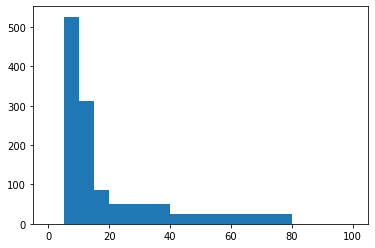

In [12]:
plt.hist(params["mse_error"],bins=BINS)
plt.show()

### Uniform Weight Specialized

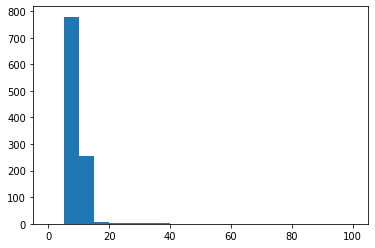

In [13]:
plt.hist(spec_params["mse_error"], bins=BINS)
plt.show()

### Randomly weighted Specialized

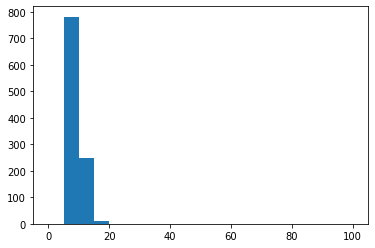

In [14]:
plt.hist(weighted_spec_params["mse_error"], bins=BINS)
plt.show()

### Configuration Model Based on Specialized Network Degree Distribution

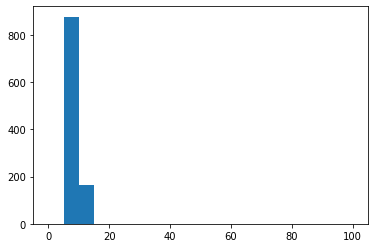

In [15]:
plt.hist(config_params["mse_error"], bins=BINS)
plt.show()

### Configuration with Randomized Weights

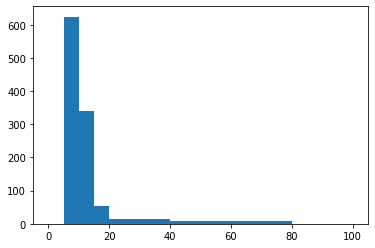

In [19]:
plt.hist(weighted_config_params["mse_error"], bins=BINS)
plt.show()

### Random graph with uniform weights

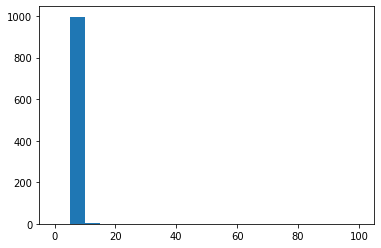

In [22]:
plt.hist(uniform_random_params["mse_error"], bins=BINS)
plt.show()

Is the last set of graph have a different computationally? More edges? 
Save high performing nodes and specialize etc.